In [47]:
%matplotlib inline
import numpy as np
import importlib as imp
import scipy.cluster as cluster
import scipy.spatial as spatial

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility
import matplotlib.pyplot as plt

In [48]:
p                       = 10
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
adj_mat[1,3]            = 1
adj_mat[0,2]            = 1
adj_mat[8,9]            = 1
connection_strength     = 0.5
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
n                       = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 400
ntrials_test                                        = 400
simulation                                          = sim.integroDifferential_simulator()
simulation.dynamic_parameters["connectivity_relaxations_constants"] = [[0.,8.],[8,0.]]
connectivity_relaxation = 10.
(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params,
                                                                                           connectivity_relaxation = connectivity_relaxation)

Plot a few samples to see the generated time series.

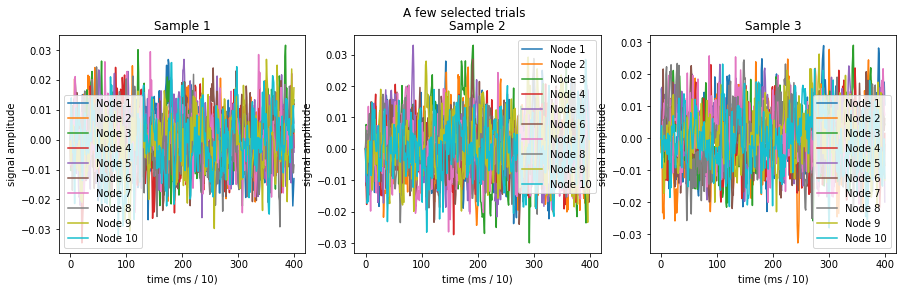

In [49]:
utility.plot_samples(training_samples[0:3])

In [50]:
reload(gpcake)
reload(utility)
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

In [51]:
cake.dynamic_parameters = simulation.dynamic_parameters

In [52]:
results = cake.empirical_bayes_parameter_fit(training_samples)

In [53]:
results

([[[], array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]), array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00])],
  [array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
            1.22762657e+00]),
   [],
   array([  1.73532968e-02,   4.90513998e+01,   3.47269369e-02,
        

In [54]:
adj_mat

array([[ 0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [55]:
scale_matrix = utility.nested_map(lambda L: L[1],
                                  utility.fill_diagonal(results[0],4*[0]))

In [56]:
scale_matrix

[[0,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426],
 [49.051399764223426,
  0,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426,
  49.051399764223426],
 [51.482406633872912,
  51.482406633872912,
  0,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912],
 [51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  0,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912],
 [51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  0,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  51.482406633872912,
  5

In [57]:
all([True,True,True])

True

In [58]:
#A = [[ np.array([2,1]),np.array([1,2]),np.array([6,3])], [np.array([24,3]),np.array([71,-2]),np.array([7,9]), [] ]]
#utility.nested_foldRight(lambda X,y: min(X[0], y),  min, 1000, A)
B = [np.array([24,3]),np.array([71,-2]),np.array([7,9]), [] ]
C = [[4, 3], [5, 13], [0, 7], []]
D = [[4], [5], [0], []]
utility.foldRight(lambda X,y: min(X, y), 1000, D)

#utility.nested_foldRight(lambda X,y: min(X[1], y), min,  1000,  A)

1000

In [59]:
float("inf")

inf

In [60]:
utility.foldRight(min, -4, [6, []])

-4